In [17]:
import math
import random
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in tuple(v._prev):
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot
    

In [24]:
class Scalar:

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0.0
        self._op = _op
        self._prev = set(_children)
        self._backward = lambda: None

    def __repr__(self):
        return f"Scalar(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Scalar) else Scalar(other)
        out = Scalar(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
        
    def __mul__(self, other):
        other = other if isinstance(other, Scalar) else Scalar(other)
        out = Scalar(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad 
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Scalar(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        return out


    def sigmoid(self):
        ## TODO: implement sigmoid func
        return 0.0

    def ReLU(self):
        ## TODO: implement ReLU func
        return 0.0

    def tanh(self):
        x = (math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1)
        out = Scalar(x, (self,), 'tanh')

        def _backward():
            self.grad += (1-x**2) * out.grad
        out._backward = _backward
        
        return out

    def backward_prop(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad=1.0
        for node in reversed(topo):
            node._backward()


    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [25]:
class Neuron:

    def __init__(self, noinp):
        self.w = [Scalar(random.uniform(1, -1)) for _ in range(noinp)]
        self.b = Scalar(random.uniform(1, -1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, noinp, noout):
        self.neurons = [Neuron(noinp) for _ in range(noout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]

class MLP:
    
    def __init__(self, noinp, noouts):
        size = [noinp] + noouts
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(noouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]
        
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.5178730093453352, grad=0.0)

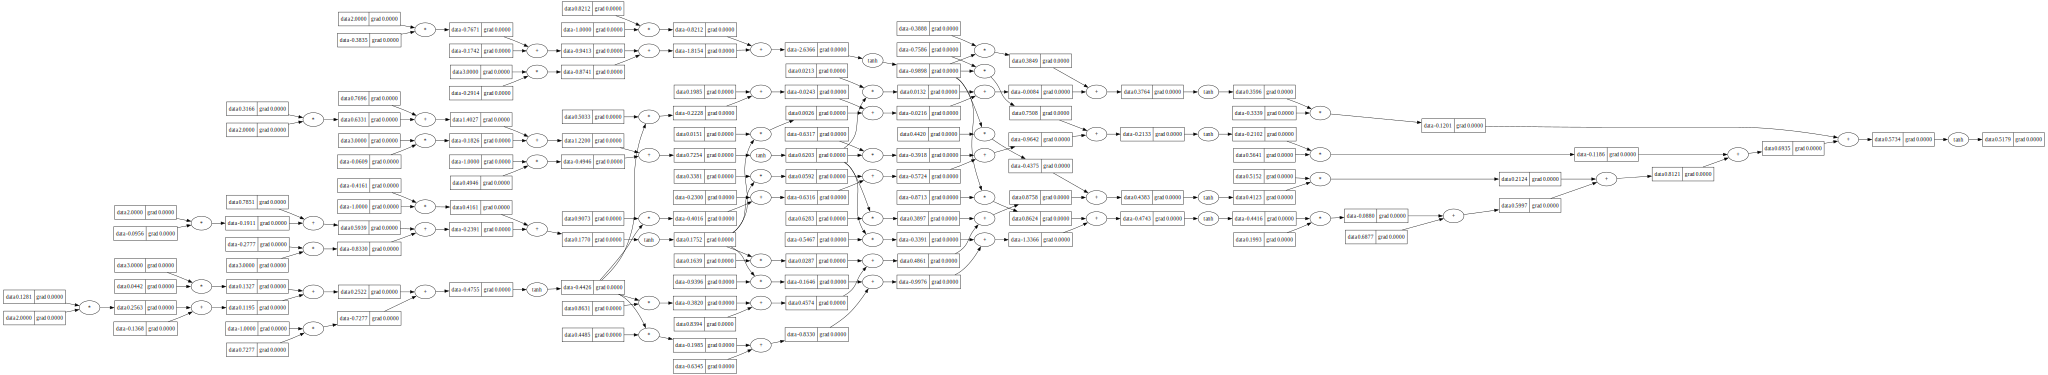

In [26]:
draw_dot(n(x))

In [27]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [28]:
for k in range(20):

    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    for param in n.parameters():
        param.grad = 0.0

    loss.backward_prop()

    for param in n.parameters():
        param.data += -0.05 * param.grad

    print(k, loss.data)

0 6.0928217368764646
1 3.895807021185944
2 1.8193197515568005
3 0.8348367205020327
4 0.4417115731722434
5 0.3046666416514252
6 0.22805482402902755
7 0.18003017384474101
8 0.14755673942098146
9 0.12434668386508244
10 0.10704186712594776
11 0.09370493225096577
12 0.08314830627539593
13 0.07460755639818781
14 0.06757043880528185
15 0.061681964102726486
16 0.056689004349939676
17 0.052406590197777186
18 0.048696655581739585
19 0.04545420908333872
